<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Откройте-и-изучите-файл" data-toc-modified-id="Откройте-и-изучите-файл-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Откройте и изучите файл</a></span></li><li><span><a href="#Разбейте-данные-на-выборки" data-toc-modified-id="Разбейте-данные-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разбейте данные на выборки</a></span></li><li><span><a href="#Исследуйте-модели" data-toc-modified-id="Исследуйте-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследуйте модели</a></span></li><li><span><a href="#Проверьте-модель-на-тестовой-выборке" data-toc-modified-id="Проверьте-модель-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверьте модель на тестовой выборке</a></span></li><li><span><a href="#(бонус)-Проверьте-модели-на-адекватность" data-toc-modified-id="(бонус)-Проверьте-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>(бонус) Проверьте модели на адекватность</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

    Импортирую всё, что буду использовать в проекте

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
display(data)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [3]:
data.info()
data.is_ultra.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


0    2229
1     985
Name: is_ultra, dtype: int64

    Данные представленны в нужных типах

In [4]:
display(data.isna().sum())
display((100 * data.isna().sum() / len(data)).round(2))

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

    Пропусков нет

In [5]:
display(data.duplicated().sum())

0

    Повторов нет

## Разбейте данные на выборки

In [6]:
X = data.drop(['is_ultra'], axis=1)
y = data['is_ultra']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify = y) #'stratify = y' для защиты от дисбаланса

display(y_train.value_counts(),
y_test.value_counts(), 
       (100 * y_train.value_counts() / len(y_train)).round(2), 
       (100 * y_test.value_counts() / len(y_test)).round(2))

0    1783
1     788
Name: is_ultra, dtype: int64

0    446
1    197
Name: is_ultra, dtype: int64

0    69.35
1    30.65
Name: is_ultra, dtype: float64

0    69.36
1    30.64
Name: is_ultra, dtype: float64

    Разделил данные в пропорции 1:4

## Исследуйте модели

    Проверку гиперпараметров моделей можно провести вручную, а можно с помощью инструментов библиотеки sci-kit learn, например GridSearchCV.
    Каждая модель была проверена на тренировочной выборке и для каждой подобраны оптимальные гиперпараметры.

    Сначала выясняю какие гиперпараметры модели дерева принятия решений покажут наилучший результат на тренировочной выборке

In [7]:
dtc = DecisionTreeClassifier()
param_grid = {
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [i for i in range(1, 11)],
    'max_features' : [2, 3, 4]
    }
CV_dtc = GridSearchCV(dtc, 
                      param_grid = param_grid, 
                      cv = None
                      )
CV_dtc.fit(X_train, y_train)
print("Лучшие гиперпараметры ", CV_dtc.best_params_)
print("Точность :", CV_dtc.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Лучшие гиперпараметры  {'criterion': 'gini', 'max_depth': 7, 'max_features': 2}
Точность : 0.8004667444574096


Затем аналогично для 'случайного леса'

In [8]:
rfc = RandomForestClassifier()
param_grid = { 
    'n_estimators': [i for i in range(1, 11)],
    'max_depth' : [i for i in range(1, 11)],
    'max_features' : [2, 3, 4]
}
CV_rfc = GridSearchCV(rfc, 
                      param_grid = param_grid, 
                      cv = None
                      )
CV_rfc.fit(X_train, y_train)

print("Лучшие гиперпараметры", CV_rfc.best_params_)
print("Точность :", CV_rfc.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Лучшие гиперпараметры {'max_depth': 10, 'max_features': 3, 'n_estimators': 9}
Точность : 0.8082458187475691


    Модель логистической регрессии не требует настройки критических гиперпараметров(с) Tune Hyperparameters for Classification Machine Learning Algorithms by Jason Brownlee on December 13, 2019 in Python Machine Learning
    Но для справедливого анализа каждой модели нужно провести проверку

In [9]:
lr = LogisticRegression(solver = 'liblinear')
param_grid = {
    "C" : [100, 10, 1.0, 0.1, 0.01], 
    'max_iter' : [100, 700, 10000], 
    'dual' : [False, True]
    }
CV_lr=GridSearchCV(lr, 
                   param_grid = param_grid, 
                   cv = None, 
                   )
CV_lr.fit(X_train, y_train)
print("Лучшие гиперпараметры",CV_lr.best_params_)
print("Точность :",CV_lr.best_score_)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

Лучшие гиперпараметры {'C': 100, 'dual': False, 'max_iter': 100}
Точность : 0.7125632049786076


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
print("Лучшие гиперпараметры",CV_lr.best_params_)

Лучшие гиперпараметры {'C': 100, 'dual': False, 'max_iter': 100}


    Лучшие результаты на тренировочной выборке показала модель RandomForestClassifier. Результаты LogisticRegression самые слабые.
    Поэтому для решения поставленной задачи предпочтительнее использовать 'случайный лес'

## Проверьте модель на тестовой выборке

Имя модели: точность на тренировочной выборке(среднее квадратичное отклонение) / точность на тестовой выборке выборке
LR: train = 0.709 (0.020) / test = 0.733
CART: train = 0.788 (0.010) / test = 0.776
RF: train = 0.804 (0.023) / test = 0.806


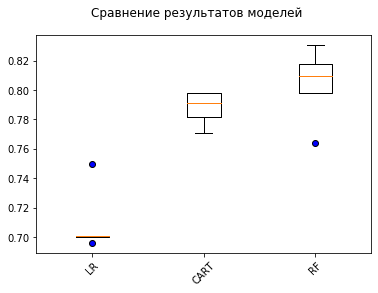

In [11]:
models = []                # создаю список имен моделей и самих моделей с самыми подходящими гиперпараметрами 
models.append(('LR', CV_lr.best_estimator_))
models.append(('CART', CV_dtc.best_estimator_))
models.append(('RF', CV_rfc.best_estimator_))

scores = []
names = []
results = []
predictions = []
out_row = []
print('Имя модели: точность на тренировочной выборке(среднее квадратичное отклонение) / точность на тестовой выборке выборке')
for name, model in models: # в цикле прохожу по каждой модели
    cv_results = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
    names.append(name)
    results.append(cv_results)
    fit = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    predictions.append(predict)
    score = model.score(X_test, y_test)
    scores.append(score)
    out = "%s: train = %.3f (%.3f) / test = %.3f" % (name, cv_results.mean(), cv_results.std(), score)
    out_row.append(out)
    print(out)
fig = pyplot.figure()
fig.suptitle('Сравнение результатов моделей ')
ax = fig.add_subplot(111)
red_square = dict(markerfacecolor='b', marker='o')
pyplot.boxplot(results, flierprops=red_square)
ax.set_xticklabels(names, rotation=45)
pyplot.show()

## (бонус) Проверьте модели на адекватность

In [12]:
dc = DummyClassifier(strategy='most_frequent', random_state=0)
dc.fit(X_train, y_train)
print(dc.score(X_test, y_test))

0.6936236391912908


    Результат DummyClassifier, оказался ниже всех обученных моделей.